## Testing look-elsewhere effect from combining two searches for the same particle using Gaussian Processes

by Kyle Cranmer, Dec 17, 2015

The correction for 1d look-elsewhere effect (LEE) presented in 
*Trial factors or the look elsewhere effect in high energy physics* by  Ofer Vitells and Eilam Gross http://arxiv.org/abs/arXiv:1005.1891

It is often claimed that when one has two statistically independent searches for the same particle, then a peak in one tells you where to look for the other, thus eliminating the look-elsewhere effect. These searches might be from two different experiments (eg. ATLAS and CMS), two different decay modes, or two different time perieods (eg. run1 and run2).  There are various flaws in this logic, as stressed by Bob Cousins in 
[these slides](https://indico.cern.ch/event/233551/contribution/1/attachments/389867/542286/cousins_look_elsewhere_14feb2013.pdf).
This issue quickly becomes subtle as the intuitive procedure of using the location of the excess in one search to inform where to look in the other is not fully specified. A few things can be said about the intuitive procedure
   * there is a symmetry of switching search1 and search2, so any approach that breaks this symmetry is going to have some weird properties. Our inference should not depend on the order!
   * you can decide to break that symmetry by picking one of the searches (without seeing the results) in order to have the correct Type-I error rate (coverage), but that will lead to sub-optimal inference. (And Cousins has pointed out that there may be something insightful to say by connecting to "Buehler's betting game")
   * if you use search 1 to *approximately* specify the location of the bump for search 2, then there is still a residual LEE for search 2 (though it will be considerably smaller)
   * The combined result doesn't depend on the order, but clearly has a look-elsewhere effect that needs to be corrected
   
In what follows I will explore the behavior of the LEE correction for the combination of two searches (which can be trivially extended to more than two searches).

### Formalism

The starting point is to consider a search for a new particle with signal strength $\mu$ and unknown mass $\nu$ on top of a background distribution described by some nuisance parameters $\theta$. We perform the search by scanning over the mass $\nu$ and calculating the test statistic

\begin{equation}
q(\nu) = -2 \log \frac{ \max_{\theta} L(\mu=0, \nu, \theta)}{ \max_{\mu, \theta} L(\mu, \nu, \theta)}
\end{equation}

Assuming the background-only is true, $q(\nu)$ is a chi-square random field (with 1 degree of freedom). That means that, for any point $\nu$, the quantity $q(\nu)$ would have a chi-square distribution if you repeated the experiment many times.  

The maximum local significance is based on $Z_{local} = \sqrt{q_{max}}$, where $q_{max} = \max_\nu q(\nu)$.
The correction from local to global significance is given by:

\begin{equation}
p_{global} = p_{local} + N \exp(-(q_{max}-u_0)/2)
\end{equation}

where $N$ is the average number of upcrossings above level $u_0$ (i.e. times that $q(\nu) > u_0$).
This $N$ characterizes the search -- searches with good mass resolution over a large mass range will have large values of $N$, while searches with poor mass resolution will have small values of $N$.

### Shortcut: Gaussian Processes

Creating many likelihood scans from pseudo-experiments (toy Monte Carlo) is somewhat time consuming, so here we make realizations of a chi-square random field by using a Gaussian Process. 
The main trick we will use is that a chi-square distribution for one degree of freedom is the same as the distribution of $x^2$ if $x$ is normally distributed. As you might have guessed, a Gaussian Process (GP) is like a chi-square random field, but it is Gaussian-distributed at each point. 

Note, the distributions are not independent at each point, there is some covariance. So if the $q(\nu)$ is high at one point, you can expect it to be high near by. We can control this behavior via the GP's kernel. In particular, 
$K(\nu_1, \nu_2) = Cov[q(\nu_1)^2, q(\nu_2)^2]$. We can essentially specify what the mass resolution of our virtual search is via the length scale used in ther kernel.

The other important thing here is to remember the asymptotic approximations state that assuming background-only ($\mu=0$) the distribution of the best fit signal strength $\hat{mu}$ follows a Gaussian distribution $G(\hat{\mu} | \mu=0, \sigma)$, so $q(\mu) = $(\hat{\mu})^2/\sigma^2$, where $\hat{\mu}$ 

For more on the theory of Gaussian Processes, the best resource is available for free online: [Rasmussen & Williams (2006)](http://www.gaussianprocess.org/gpml/). We will [`george`](http://dan.iel.fm/george/current/) -- a nice python package for Gaussian Processes (GP).

### Basic outline of what will be shown below

We will create three different Gaussian Processes:
   * `gp1` will generate results from experiment 1 
   * `gp2` will generate results from experiment 2
   * we will explicitly combine the results from experiments 1 and 2
   * `gp12` will be shown to have the same behavior as the combination of `gp1` and `gp2`


In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


The main trick we will use is that a chi-square distribution for one degree of freedom is the same as the distribution of $x^2$ if $x$ is normally distributed. Here's a quick demonstration of that:

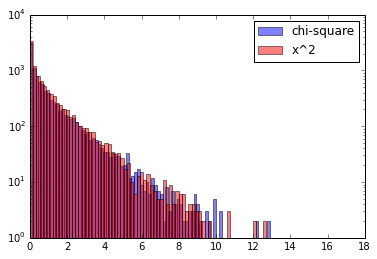

In [2]:
from scipy.stats import chi2, norm
chi2_array = chi2.rvs(1, size=10000)
norm_array = norm.rvs(size=10000)
_ = plt.hist(chi2_array, bins=100, alpha=.5, label='chi-square')
_ = plt.hist(norm_array**2, bins=100, alpha=.5, color='r', label='x^2')
plt.yscale('log', nonposy='clip')
plt.legend(('chi-square', 'x^2'))
#plt.semilogy()

### Ok, now to the Gaussian processes.

In [3]:
import george
from george.kernels import ExpSquaredKernel

In [161]:
length_scale_of_correaltion=1.
ratio_of_correlations=10.
kernel1 = ExpSquaredKernel(length_scale_of_correaltion, ndim=1)
kernel2 = ExpSquaredKernel(ratio_of_correlations**2*length_scale_of_correaltion, ndim=1)
kernel12 = 0.5*kernel1+0.5*kernel2

In [162]:
# Create the Gaussian process
# gp = george.GP(kernel)
gp1 = george.GP(kernel1, solver=george.HODLRSolver) #faster
gp2 = george.GP(kernel2, solver=george.HODLRSolver) #faster
gp12 = george.GP(kernel12, solver=george.HODLRSolver) #faster

In [163]:
n_scan_points=250
x = np.linspace(0,100,n_scan_points)

In [164]:
# slow part: pre-compute internal stuff for the GP
gp1.compute(x)
gp2.compute(x)
gp12.compute(x)

In [165]:
# evaluate one realization of the GP
z = gp1.sample(x)

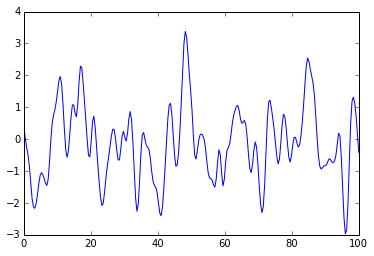

In [166]:
# plot the chi-square random field
plt.plot(x,z)

Now lets histogram the values of the random field.
Don't get confused here... if you pick a single point and histogram the value of over many instances, you expect a Gaussian. However, for a single instance, you don't expect the histogram for the value of the field to be Gaussian (because of the correlations). Thought experiments: if you make `length_scale_of_correaltion` very small, then each point is essentially independent and you do expect to see a Gaussian; however, if `length_scale_of_correaltion` is very large then you expect the field to be nearly constant and the histogram below would be a delta function.

## Define some quick helper functions

In [167]:
def q_to_pvalue(q):
    return (1.-chi2.cdf(q, 1))/2 #divide by 2 for 1-sided test

def pvalue_to_significance(p):
    return -norm.ppf(p)

def significance_to_pvalue(Z):
    return 1.-norm.cdf(Z)

In [168]:
def num_upcrossings(z):
    """count number of times adjacent bins change between 0,1"""
    return np.sum((z-np.roll(z,1))**2)/2

In [169]:
def global_pvalue(u,u0, n):
    return (1.-chi2.cdf(u, 1))/2. + np.exp(-(u-u0)/2)*n

In [170]:
q_to_pvalue(2.6**2)

0.004661188023718732

In [171]:
significance_to_pvalue(2.6)

0.004661188023718732

In [172]:
pvalue_to_significance(0.00466)

2.6000874741599374

In [173]:
global_pvalue(0.001,.1,0.1)

0.59246099890646264

In [174]:
u1 = 1.

17.0
24.0
19.0
n_av =  18.72


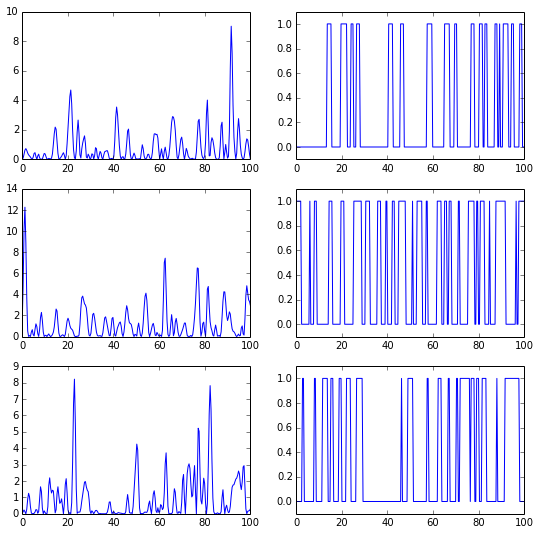

In [175]:
n_samples = 25
z_array = gp1.sample(x,n_samples)

q_max = np.zeros(n_samples)
phis = np.zeros((n_samples,2))

n_av = 0.
n_plots = 3
plt.figure(figsize=(9,n_plots*3))
for scan_no, z in enumerate(z_array):

    scan = z**2

    q_max[scan_no] = np.max(scan)
    
    exc1 = (scan>u1) + 0. #add 0. to convert from bool to double
    
    if scan_no < n_plots:
        aspect = 1.
        plt.subplot(n_plots,2,2*scan_no+1)
        plt.plot(x,scan)
        plt.subplot(n_plots,2,2*scan_no+2)
        plt.plot(x,exc1)
        plt.ylim(-.1,1.1)
        print num_upcrossings(exc1)
    n_av += 1.*num_upcrossings(exc1)/n_samples

print "n_av = ", n_av



12.0
12.0
17.0
n_av =  13.636


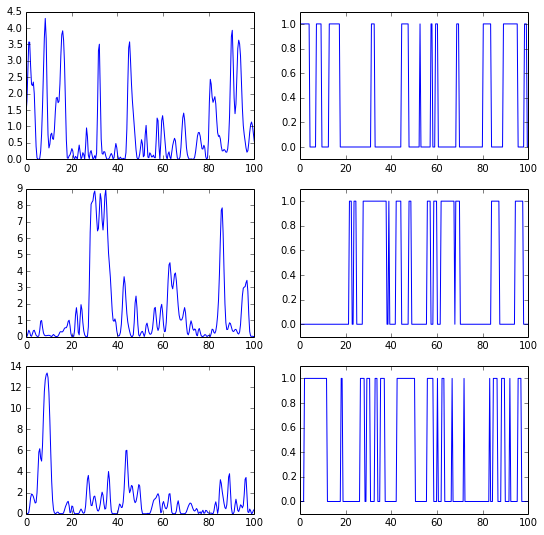

In [176]:
n_samples = 500
z_array = gp12.sample(x,n_samples)

q_max = np.zeros(n_samples)
phis = np.zeros((n_samples,2))

n_av = 0.
n_plots = 3
plt.figure(figsize=(9,n_plots*3))
for scan_no, z in enumerate(z_array):

    scan = z**2

    q_max[scan_no] = np.max(scan)
    
    exc1 = (scan>u1) + 0. #add 0. to convert from bool to double
    
    if scan_no < n_plots:
        aspect = 1.
        plt.subplot(n_plots,2,2*scan_no+1)
        plt.plot(x,scan)
        plt.subplot(n_plots,2,2*scan_no+2)
        plt.plot(x,exc1)
        plt.ylim(-.1,1.1)
        print num_upcrossings(exc1)
    n_av += 1.*num_upcrossings(exc1)/n_samples

print "n_av = ", n_av




In [177]:
u = np.linspace(5,25,100)
global_p = global_pvalue(u,u1,n_av)

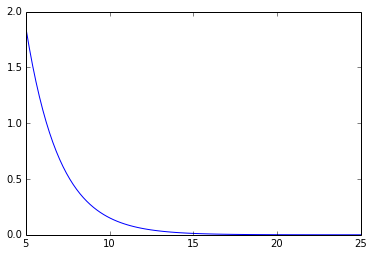

In [178]:
plt.plot(u,global_p)

### Generate 5000 instances of the Gaussian Process, find maximum local significance for each, and check the prediction for the LEE-corrected global p-value

In [179]:
n_samples = 10000
z_array = gp1.sample(x,n_samples)

q_max = np.zeros(n_samples)

for scan_no, z in enumerate(z_array):
    scan = z**2
    q_max[scan_no] = np.max(scan)

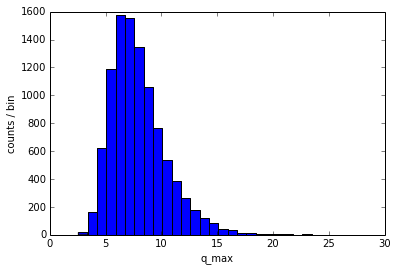

In [180]:
bins, edges, patches = plt.hist(q_max, bins=30)
icdf = 1.-np.cumsum(bins/n_samples)
icdf = np.hstack((1.,icdf))
icdf_error = np.sqrt(np.cumsum(bins))/n_samples
icdf_error = np.hstack((0.,icdf_error))
plt.xlabel('q_max')
plt.ylabel('counts / bin')

[]

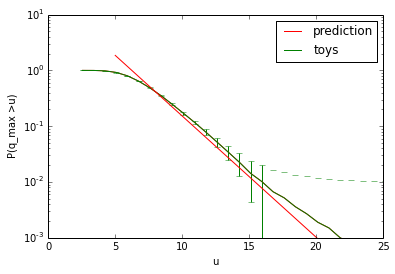

In [181]:
# plot the p-value 
#plt.subplot(121)
#plt.plot(edges,icdf, c='r')
#plt.errorbar(edges,icdf,yerr=icdf_error)
#plt.plot(u, global_p)
#plt.xlabel('u')
#plt.ylabel('P(q_max >u)')
#plt.xlim(0,25)
#plt.subplot(122)
plt.plot(edges,icdf, c='r', label='toys')
plt.errorbar(edges,icdf,yerr=icdf_error)
plt.plot(u, global_p, label='prediction')
plt.xlabel('u')
plt.ylabel('P(q_max >u)')
plt.legend(('prediction','toys'))
#plt.ylabel('P(q>u)')
plt.ylim(1E-3,10)
plt.xlim(0,25)
plt.semilogy()

n_av =  19.1667 2.1543 13.6643


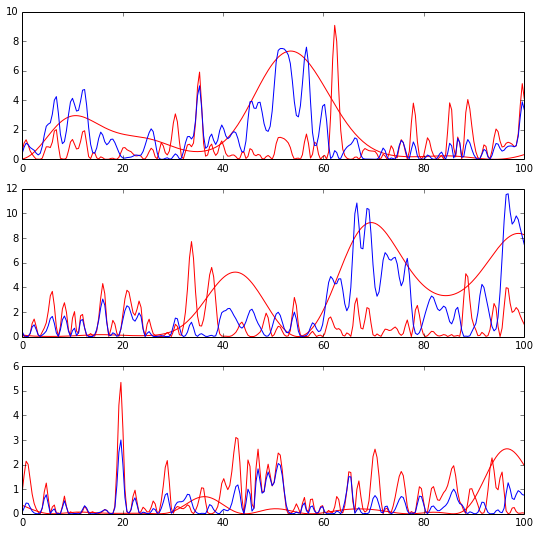

In [182]:
n_samples = 10000
z_array1 = gp1.sample(x,n_samples)
z_array2 = gp2.sample(x,n_samples)


n_av1, n_av2, n_av12 = 0., 0., 0.
q_max = np.zeros((n_samples,3))

q_10 = np.zeros((n_samples,3))

n_plots = 3
plt.figure(figsize=(9,n_plots*3))
scan_no=0
for z1, z2 in zip(z_array1,z_array2):
    
    scan1  = z1**2
    scan2  = z2**2
    scan12 = ((z1+z2)**2)/2

    exc1 = (scan1>u1) + 0. #add 0. to convert from bool to double
    exc2 = (scan2>u1) + 0. #add 0. to convert from bool to double
    exc12 = (scan12>u1) + 0. #add 0. to convert from bool to double
    
    if scan_no < n_plots:
        aspect = 1.
        #plt.subplot(n_plots,3,3*scan_no+1)
        plt.subplot(n_plots,1,1*scan_no+1)
        plt.plot(x,scan1, c='r')
        #plt.subplot(n_plots,3,3*scan_no+2)
        plt.subplot(n_plots,1,1*scan_no+1)
        plt.plot(x,scan2, c='r')
        #plt.subplot(n_plots,3,3*scan_no+3)
        plt.subplot(n_plots,1,1*scan_no+1)        
        plt.plot(x,scan12, c='b')

    q_max[scan_no,:] = [np.max(scan1), np.max(scan2), np.max(scan12)]
    q_10[scan_no,:] = [scan1[10],scan2[10], scan12[10]]

        
    #print num_upcrossings(exc1)
    n_av1 += 1.*num_upcrossings(exc1)/n_samples
    n_av2 += 1.*num_upcrossings(exc2)/n_samples
    n_av12 += 1.*num_upcrossings(exc12)/n_samples
    scan_no +=1




print "n_av = ", n_av1, n_av2, n_av12




In [183]:
n_samples = 10000
z_array12 = gp12.sample(x,n_samples)

q12_max = np.zeros((n_samples))

for scan_no, z12 in enumerate(z_array12):
    scan12 = (z12)**2
    q12_max[scan_no] = np.max(scan12)


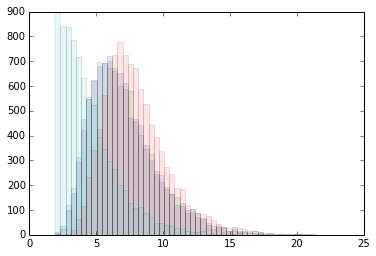

In [186]:
#count, edges, patches = plt.hist(q_max[:,0], bins=50, alpha=0.1)
#count, edges, patches = plt.hist(q_max[:,1], bins=edges, alpha=0.1)
#count, edges, patches = plt.hist(q_max[:,2], bins=edges, alpha=0.1)
count, edges, patches = plt.hist(q_max[:,2], bins=50, alpha=0.1)
count, edges, patches = plt.hist(q12_max, bins=edges, alpha=0.1)
count, edges, patches = plt.hist(q_max[:,0], bins=edges, alpha=0.1)
count, edges, patches = plt.hist(q_max[:,1], bins=edges, alpha=0.1)



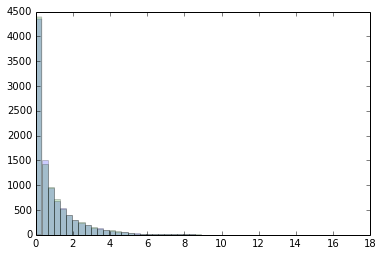

In [123]:
count, edges, patches = plt.hist(q_10[:,0], bins=50, alpha=0.2)
#count, edges, patches = plt.hist(q_10[:,1], bins=edges, alpha=0.1)
#count, edges, patches = plt.hist(q_10[:,2], bins=edges, alpha=0.1)
count, edges, patches = plt.hist(norm_array**2, bins=edges, alpha=0.2)